#Imports

In [ ]:
import os
import kagglehub
import sys
import json
import math
import pickle
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import cv2


In [ ]:
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


#VIT MODEL

In [ ]:
class NewGELUActivation(nn.Module):
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [ ]:



class AttentionHead(nn.Module):
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = config["qkv_bias"]
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = config["qkv_bias"]
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        qkv = self.qkv_projection(x)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        attention_output = torch.matmul(attention_probs, value)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)

In [ ]:

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [ ]:


def save_checkpoint(exp_name, model, epoch, optimizer=None):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
    }
    checkpoint_path = f'{exp_name}_checkpoint_epoch_{epoch}.pt'
    torch.save(checkpoint, checkpoint_path)
    print(f'Model checkpoint saved to {checkpoint_path}')




In [ ]:
config = {
    "patch_size": 4,
    "hidden_size": 96,
    "num_hidden_layers": 8,
    "num_attention_heads": 8,
    "intermediate_size": 4 * 96,
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 64,
    "num_classes": 15,
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


In [ ]:


class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.best_train_accuracy = 0
        self.best_epoch = 0

    def train(self, trainloader, val_loader, testloader, epochs, save_model_every_n_epochs=0):
        train_losses, val_losses, val_accuracies, train_accuracies = [], [], [], []


        for i in range(epochs):
            train_loss, train_accuracy = self.train_epoch(trainloader)
            val_accuracy, val_loss = self.evaluate(val_loader)
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                  f"Validation loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            if train_accuracy > self.best_train_accuracy:
                self.best_train_accuracy = train_accuracy
                self.best_epoch = i + 1
                print(f'\tSaving model with best train accuracy ({train_accuracy:.4f}) at epoch {i+1}')
                save_checkpoint(self.exp_name, self.model, i + 1, self.optimizer)
        return train_losses, val_losses, val_accuracies, train_accuracies



    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0
        correct = 0
        for batch in trainloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            self.optimizer.zero_grad()
            logits, _ = self.model(images)
            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()

        avg_loss = total_loss / len(trainloader.dataset)
        accuracy = correct / len(trainloader.dataset)
        return avg_loss, accuracy

    @torch.no_grad()
    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in dataloader:
                batch = [t.to(self.device) for t in batch]
                images, labels = batch
                logits, _ = self.model(images)
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(dataloader.dataset)
        avg_loss = total_loss / len(dataloader.dataset)
        return accuracy, avg_loss

def run_experiment():
    args = SimpleNamespace(
        exp_name="plant_disease_vit",
        batch_size=32,
        epochs=30,
        lr=1e-4,
        device="cuda" if torch.cuda.is_available() else "cpu",
        save_model_every=5
    )
    batch_size = args.batch_size
    epochs = args.epochs
    lr = args.lr
    device = args.device
    save_model_every_n_epochs = args.save_model_every

    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()

    trainer = Trainer(model, optimizer, loss_fn, args.exp_name, device=device)
    train_losses, val_losses, val_accuracies,train_accuracies = trainer.train(
    train_loader, val_loader, test_loader, epochs, save_model_every_n_epochs=save_model_every_n_epochs
)
    test_accuracy, test_loss = trainer.evaluate(test_loader)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
    return train_losses, val_losses, val_accuracies,train_accuracies

#Experiment-1

##Preprocessing

In [ ]:

def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    class PlantDiseaseDataset(Dataset):
        def __init__(self, images, labels, transform=None):
            self.images = images
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = self.images[idx]
            label = self.labels[idx]
            image = Image.fromarray(image.astype('uint8'), 'RGB')
            image = self.transform(image)
            return image, label

    directory_root = "/content/archive (4).zip"
    extracted_folder = "/content/plantdisease"
    image_list, label_list = [], []

    if not os.path.exists(extracted_folder):
        print("[INFO] Extracting zip file...")
        with zipfile.ZipFile(directory_root, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder)
        print("[INFO] Extraction completed.")

    try:
        print("[INFO] Loading images ...")
        root_dirs = [d for d in os.listdir(extracted_folder) if d != ".DS_Store"]

        for plant_folder in root_dirs:
            plant_folder_path = os.path.join(extracted_folder, plant_folder)
            if not os.path.isdir(plant_folder_path):
                continue

            disease_folders = [d for d in os.listdir(plant_folder_path) if d != ".DS_Store"]

            for disease_folder in disease_folders:
                disease_folder_path = os.path.join(plant_folder_path, disease_folder)
                if not os.path.isdir(disease_folder_path):
                    continue

                image_files = [f for f in os.listdir(disease_folder_path) if f.lower().endswith(".jpg") and not f.startswith(".")]

                for image_name in image_files:
                    image_path = os.path.join(disease_folder_path, image_name)
                    try:
                        image = Image.open(image_path).convert("RGB")
                        image_list.append(np.array(image))
                        label_list.append(disease_folder)
                    except Exception as e:
                        print(f"Failed to load {image_path}: {e}")

        print("[INFO] Image loading completed")
    except Exception as e:
        print(f"[ERROR] {e}")

    le = LabelEncoder()
    encoded_labels = le.fit_transform(label_list)
    print(f"Encoded labels: {encoded_labels}")

    X_train, X_temp, y_train, y_temp = train_test_split(image_list, encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    train_dataset = PlantDiseaseDataset(X_train, y_train, transform=transform)
    val_dataset = PlantDiseaseDataset(X_val, y_val, transform=transform)
    test_dataset = PlantDiseaseDataset(X_test, y_test, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    classes = le.classes_

    return train_loader, val_loader, test_loader, classes, le




In [ ]:

train_loader, val_loader, test_loader, classes, le = prepare_data(batch_size=32, num_workers=2)

print(len(classes))
print(f"Classes: {classes}")

[INFO] Extracting zip file...
[INFO] Extraction completed.
[INFO] Loading images ...
[INFO] Image loading completed
Encoded labels: [9 9 9 ... 8 8 8]
15
Classes: ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


##Training

In [ ]:
train_losses, val_losses, val_accuracies,train_accuracies=run_experiment()

Epoch: 1, Train loss: 1.8107, Train Accuracy: 0.4105, Validation loss: 1.4474, Validation Accuracy: 0.5060
	Saving model with best train accuracy (0.4105) at epoch 1
Model checkpoint saved to plant_disease_vit_checkpoint_epoch_1.pt
Epoch: 2, Train loss: 1.2440, Train Accuracy: 0.5853, Validation loss: 1.0907, Validation Accuracy: 0.6452
	Saving model with best train accuracy (0.5853) at epoch 2
Model checkpoint saved to plant_disease_vit_checkpoint_epoch_2.pt
Epoch: 3, Train loss: 0.9385, Train Accuracy: 0.6908, Validation loss: 0.8539, Validation Accuracy: 0.7124
	Saving model with best train accuracy (0.6908) at epoch 3
Model checkpoint saved to plant_disease_vit_checkpoint_epoch_3.pt
Epoch: 4, Train loss: 0.7680, Train Accuracy: 0.7454, Validation loss: 0.7443, Validation Accuracy: 0.7586
	Saving model with best train accuracy (0.7454) at epoch 4
Model checkpoint saved to plant_disease_vit_checkpoint_epoch_4.pt
Epoch: 5, Train loss: 0.6352, Train Accuracy: 0.7861, Validation loss: 0

In [ ]:


class_names = [
    'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Tomato_Septoria_leaf_spot',
    'Tomato_Early_blight', 'Pepper__bell___Bacterial_spot', 'Potato___Late_blight',
    'Tomato_healthy', 'Potato___healthy', 'Tomato_Bacterial_spot',
    'Tomato__Tomato_mosaic_virus', 'Potato___Early_blight', 'Tomato_Late_blight',
    'Tomato__Tomato_YellowLeaf__Curl_Virus'
]

le = LabelEncoder()
le.fit(class_names)

joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:

def load_model(model, weights_path, device):
    checkpoint = torch.load(weights_path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    print(f"Model weights loaded from {weights_path}")
    return model

def load_label_encoder(encoder_path):
    return joblib.load(encoder_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForClassfication(config)
weights_path = "/content/plant_disease_vit_checkpoint_epoch_26.pt"
model = load_model(model, weights_path, device)

encoder_path = "/content/label_encoder.pkl"
le = load_label_encoder(encoder_path)

image_path = "/content/Tomato_Leaf_Mold.Mold 7055.JPG"
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

image = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image.to(device))

logits = output[0] if isinstance(output, tuple) else output

probabilities = torch.nn.functional.softmax(logits, dim=1)
_, predicted_class_idx = torch.max(probabilities, 1)
print(f"Predicted class index: {predicted_class_idx.item()}")
predicted_label = le.inverse_transform(predicted_class_idx.cpu().numpy())

print(f"Predicted Label: {predicted_label}")


Model weights loaded from /content/plant_disease_vit_checkpoint_epoch_26.pt
Predicted class index: 8
Predicted Label: ['Tomato_Leaf_Mold']


In [ ]:

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()


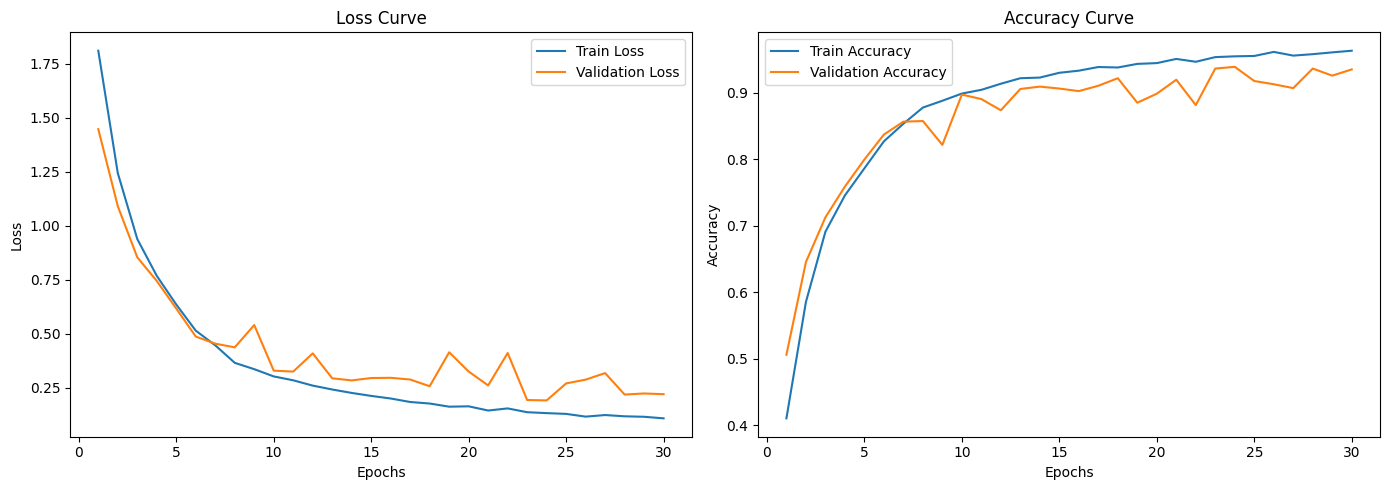

In [ ]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


In [ ]:


@torch.no_grad()
def visualize_attention(model, testset, classes, output=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    max_images = 5
    indices = torch.randperm(len(testset))

    raw_images, labels = [], []
    for i in indices[:max_images]:
        image, label = testset[i]
        raw_images.append(image)
        labels.append(label)

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    images = torch.stack([transform(img) for img in raw_images]).to(device)
    logits, attention_maps = model(images, output_attentions=True)
    predictions = torch.argmax(logits, dim=1)

    correct_predictions = (predictions.cpu() == torch.tensor(labels)).sum().item()
    total_predictions = len(labels)


    attention_maps = torch.cat(attention_maps, dim=1)
    attention_maps = attention_maps[:, :, 0, 1:]
    attention_maps = attention_maps.mean(dim=1)

    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size).unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(64, 64), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)

    correct_indices = [i for i in range(total_predictions) if predictions[i] == labels[i]]
    incorrect_indices = [i for i in range(total_predictions) if predictions[i] != labels[i]]



    selected_indices = correct_indices[:max_images - 1]
    if incorrect_indices:
        selected_indices.append(incorrect_indices[0])
    rows = math.ceil(len(selected_indices) / 2)
    fig = plt.figure(figsize=(10, 5 * rows))

    for idx, i in enumerate(selected_indices):
        ax = fig.add_subplot(rows, 2, idx + 1, xticks=[], yticks=[])

        img = raw_images[i].permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.imshow(attention_maps[i].cpu(), alpha=0.5, cmap='jet')

        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        color = "green" if gt == pred else "red"
        ax.set_title(f"gt: {gt} / pred: {pred}", color=color)

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()


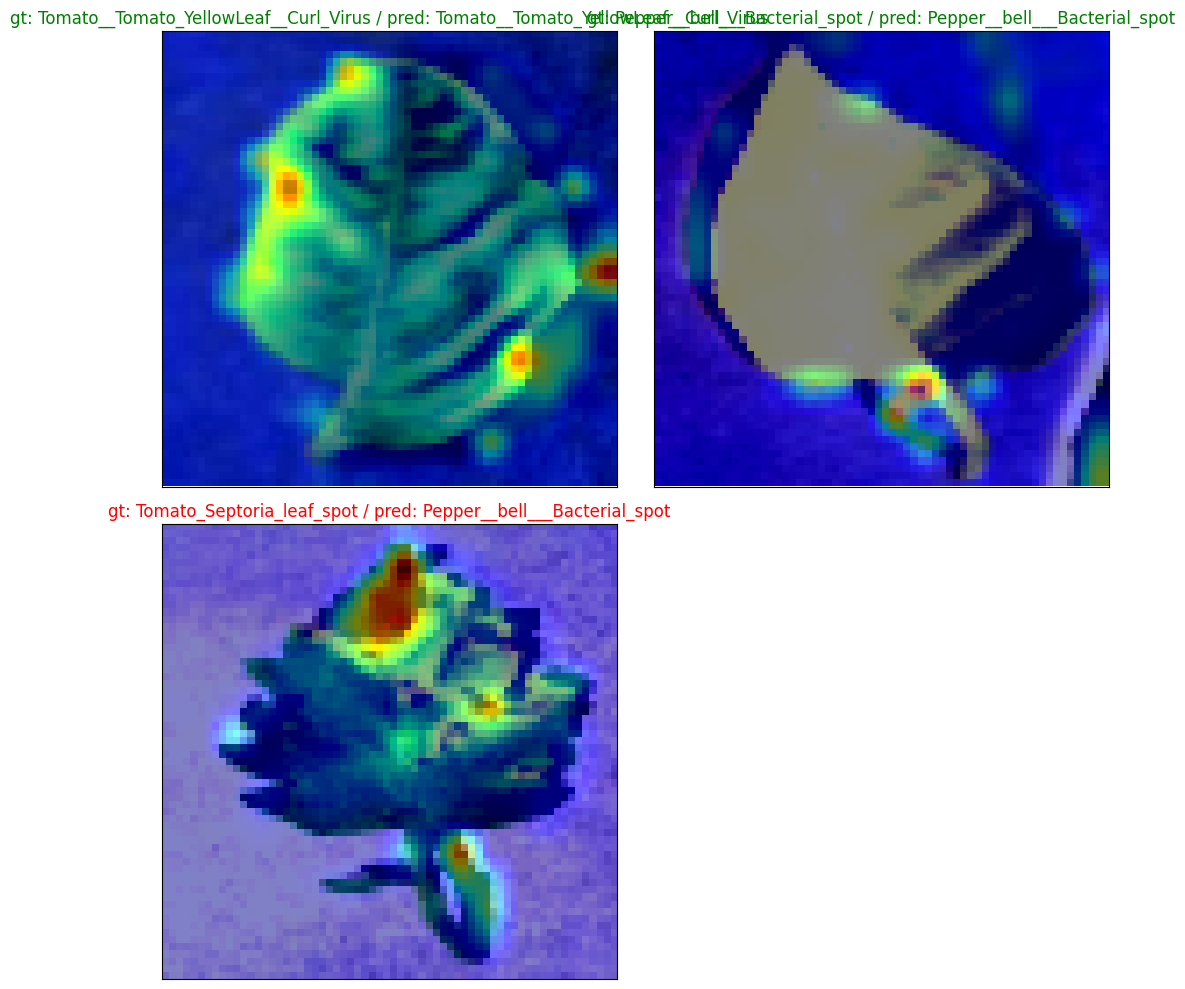

In [ ]:
testset = test_loader.dataset
visualize_attention(model, testset, classes, output="attention.png")

#Experiment-2

##Preprocessing

In [ ]:
class EdgeBoostTransform:
    def __call__(self, image):
        image_np = np.array(image)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        edges = cv2.Laplacian(gray, cv2.CV_64F)
        edges = np.uint8(np.absolute(edges))
        edge_3ch = cv2.merge([edges, edges, edges])

        blended = cv2.addWeighted(image_np, 0.8, edge_3ch, 0.2, 0)

        return transforms.ToTensor()(blended)


In [ ]:

def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):

    transform = transforms.Compose([
        EdgeBoostTransform(),
        transforms.Resize((64, 64)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    class PlantDiseaseDataset(Dataset):
        def __init__(self, images, labels, transform=None):
            self.images = images
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = self.images[idx]
            label = self.labels[idx]
            image = Image.fromarray(image.astype('uint8'), 'RGB')
            image = self.transform(image)
            return image, label

    directory_root = "/content/archive (4).zip"
    extracted_folder = "/content/plantdisease"
    image_list, label_list = [], []

    if not os.path.exists(extracted_folder):
        print("[INFO] Extracting zip file...")
        with zipfile.ZipFile(directory_root, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder)
        print("[INFO] Extraction completed.")

    try:
        print("[INFO] Loading images ...")
        root_dirs = [d for d in os.listdir(extracted_folder) if d != ".DS_Store"]

        for plant_folder in root_dirs:
            plant_folder_path = os.path.join(extracted_folder, plant_folder)
            if not os.path.isdir(plant_folder_path):
                continue

            disease_folders = [d for d in os.listdir(plant_folder_path) if d != ".DS_Store"]

            for disease_folder in disease_folders:
                disease_folder_path = os.path.join(plant_folder_path, disease_folder)
                if not os.path.isdir(disease_folder_path):
                    continue

                image_files = [f for f in os.listdir(disease_folder_path) if f.lower().endswith(".jpg") and not f.startswith(".")]

                for image_name in image_files:
                    image_path = os.path.join(disease_folder_path, image_name)
                    try:
                        image = Image.open(image_path).convert("RGB")
                        image_list.append(np.array(image))
                        label_list.append(disease_folder)
                    except Exception as e:
                        print(f"Failed to load {image_path}: {e}")

        print("[INFO] Image loading completed")
    except Exception as e:
        print(f"[ERROR] {e}")

    le = LabelEncoder()
    encoded_labels = le.fit_transform(label_list)
    print(f"Encoded labels: {encoded_labels}")

    X_train, X_temp, y_train, y_temp = train_test_split(image_list, encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    train_dataset = PlantDiseaseDataset(X_train, y_train, transform=transform)
    val_dataset = PlantDiseaseDataset(X_val, y_val, transform=transform)
    test_dataset = PlantDiseaseDataset(X_test, y_test, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    classes = le.classes_

    return train_loader, val_loader, test_loader, classes, le




In [ ]:

train_loader, val_loader, test_loader, classes, le = prepare_data(batch_size=32, num_workers=2)

print(len(classes))
print(f"Classes: {classes}")

[INFO] Loading images ...
[INFO] Image loading completed
Encoded labels: [9 9 9 ... 8 8 8]
15
Classes: ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


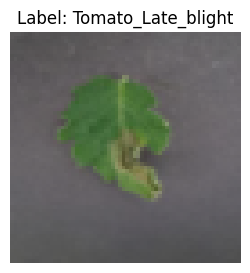

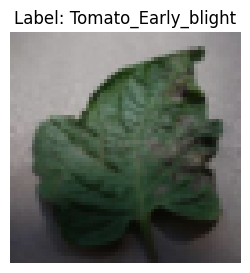

In [ ]:

data_iter = iter(train_loader)
images, labels = next(data_iter)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
for i in [1, 2]:
    img = images[i] * std + mean
    np_img = img.permute(1, 2, 0).numpy()
    label = classes[labels[i]]

    plt.figure(figsize=(3, 3))
    plt.imshow(np_img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


In [ ]:
train_losses, val_losses, val_accuracies,train_accuracies=run_experiment()

Epoch: 1, Train loss: 1.9128, Train Accuracy: 0.3713, Validation loss: 1.5430, Validation Accuracy: 0.4943
	Saving model with best train accuracy (0.3713) at epoch 1
Model checkpoint saved to plant_disease_vit_checkpoint_epoch_1.pt
Epoch: 2, Train loss: 1.2999, Train Accuracy: 0.5765, Validation loss: 1.0563, Validation Accuracy: 0.6527
	Saving model with best train accuracy (0.5765) at epoch 2
Model checkpoint saved to plant_disease_vit_checkpoint_epoch_2.pt
Epoch: 3, Train loss: 0.9022, Train Accuracy: 0.7056, Validation loss: 0.7482, Validation Accuracy: 0.7596
	Saving model with best train accuracy (0.7056) at epoch 3
Model checkpoint saved to plant_disease_vit_checkpoint_epoch_3.pt
Epoch: 4, Train loss: 0.6719, Train Accuracy: 0.7827, Validation loss: 0.6250, Validation Accuracy: 0.7952
	Saving model with best train accuracy (0.7827) at epoch 4
Model checkpoint saved to plant_disease_vit_checkpoint_epoch_4.pt
Epoch: 5, Train loss: 0.5478, Train Accuracy: 0.8188, Validation loss: 0

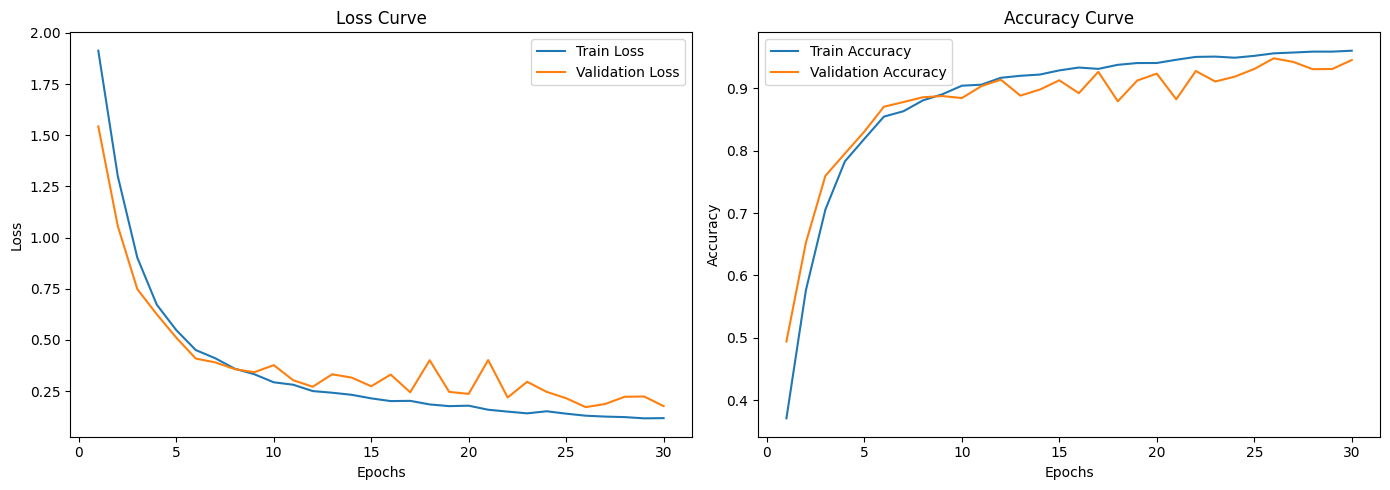

In [ ]:
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


#Fine tuning

In [ ]:

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        logp = self.ce(inputs, targets)
        p = torch.exp(-logp)
        return ((1 - p) ** self.gamma * logp).mean()


class CrossEntropyWithEntropyPenalty(nn.Module):
    def __init__(self, penalty_weight=0.01):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.penalty_weight = penalty_weight

    def forward(self, logits, labels):
        ce_loss = self.ce(logits, labels)
        probs = torch.softmax(logits, dim=1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-6), dim=1).mean()
        return ce_loss - self.penalty_weight * entropy


class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.best_accuracy = 0.0
        self.best_model_state = None

    def train(self, trainloader, testloader, epochs):
        train_losses, test_losses, accuracies = [], [], []
        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)

            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    def train_epoch(self, trainloader):
        self.model.train()
        total_loss = 0
        for batch in trainloader:
            batch = [t.to(self.device) for t in batch]
            images, labels = batch
            self.optimizer.zero_grad()
            logits, *_ = self.model(images)
            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                batch = [t.to(self.device) for t in batch]
                images, labels = batch
                logits, *_ = self.model(images)
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

In [ ]:

def parse_args():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--exp-name", type=str, required=True)
    parser.add_argument("--batch-size", type=int, default=256)
    parser.add_argument("--epochs", type=int, default=15)
    parser.add_argument("--lr", type=float, default=1e-2)
    parser.add_argument("--device", type=str)
    parser.add_argument("--save-model-every", type=int, default=0)
    return parser.parse_args()


if __name__ == "__main__":
    sys.argv = ["colab_kernel_launcher.py", "--exp-name", "experiment_name"]

    args = parse_args()

    device = args.device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-2)

    loss_functions = {
        "smooth": nn.CrossEntropyLoss(label_smoothing=0.1),
        "focal": FocalLoss(),
        "entropy": CrossEntropyWithEntropyPenalty(),
    }

    for loss_name, loss_fn in loss_functions.items():
        print(f"Training with loss function: {loss_name}")
        trainer = Trainer(model, optimizer, loss_fn, args.exp_name, device=device)
        trainer.train(train_loader, test_loader, args.epochs)


Training with loss function: smooth
Epoch: 1, Train loss: 2.2978, Test loss: 1.5253, Accuracy: 0.6340
Epoch: 2, Train loss: 1.3420, Test loss: 1.1307, Accuracy: 0.7904
Epoch: 3, Train loss: 1.1145, Test loss: 1.2488, Accuracy: 0.7584
Epoch: 4, Train loss: 1.0404, Test loss: 1.0768, Accuracy: 0.8127
Epoch: 5, Train loss: 1.0055, Test loss: 1.0751, Accuracy: 0.8421
Epoch: 6, Train loss: 0.9846, Test loss: 0.8600, Accuracy: 0.9105
Epoch: 7, Train loss: 0.9488, Test loss: 1.0423, Accuracy: 0.8630
Epoch: 8, Train loss: 0.9475, Test loss: 0.8841, Accuracy: 0.9041
Epoch: 9, Train loss: 0.9355, Test loss: 0.9988, Accuracy: 0.8469
Epoch: 10, Train loss: 0.9550, Test loss: 0.9060, Accuracy: 0.9067
Epoch: 11, Train loss: 0.9343, Test loss: 0.8440, Accuracy: 0.9105
Epoch: 12, Train loss: 0.9227, Test loss: 1.0195, Accuracy: 0.8340
Epoch: 13, Train loss: 0.8622, Test loss: 0.8649, Accuracy: 0.9057
Epoch: 14, Train loss: 0.9143, Test loss: 0.9318, Accuracy: 0.8992
Epoch: 15, Train loss: 0.8698, Test